In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import (
    linear_model, metrics, neural_network, pipeline, preprocessing, model_selection
)

%matplotlib inline

* Recidivism is the tendency for an individual who has previously committed a crime to commit another crime in the future.

### The findings of the Pro Publica article:

* Black defendants were often predicted to be at a higher risk of recidivism than they actually were.

* White defendants were often predicted to be less risky than they were.

* When controlling for prior crimes, future recidivism, age, and gender, black defendants were 45 percent more likely to be assigned higher risk scores than white defendants.

* Black defendants were twice as likely as white defendants to be misclassified as being a higher risk of violent recidivism.

* Even when controlling for prior crimes, future recidivism, age, and gender, black defendants were 77 percent more likely to be assigned higher risk scores than white defendants.

In [2]:
data_url = "https://raw.githubusercontent.com/propublica/compas-analysis"
data_url += "/master/compas-scores-two-years.csv"

df = pd.read_csv(data_url)
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


* first: An individual’s first name

* last: An individual’s last name

* sex: An individual’s sex

* age: An individual’s age

* race: An individual’s race. It takes values of Caucasian, Hispanic, African-American, Native American, Asian, or Other

* priors_count: Number of previous arrests

* decile_score: The COMPAS risk score

* two_year_recid: Whether the individual had been jailed for a new crime in next two years



# Descriptive Statistics

In [3]:
race_count = df.groupby(["race"])["name"].count()
at_least_500 = list(race_count[race_count > 500].index)
print("The following race have at least 500 observations:", at_least_500)
df = df.loc[df["race"].isin(at_least_500), :]

The following race have at least 500 observations: ['African-American', 'Caucasian', 'Hispanic']


In [4]:
def create_groupcount_barplot(df, group_col, figsize, **kwargs):
    "call df.groupby(group_col), then count number of records and plot"
    counts = df.groupby(group_col)["name"].count().sort_index()

    fig, ax = plt.subplots(figsize=figsize)
    counts.plot(kind="bar", **kwargs)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_xlabel("")
    ax.set_ylabel("")

    return fig, ax

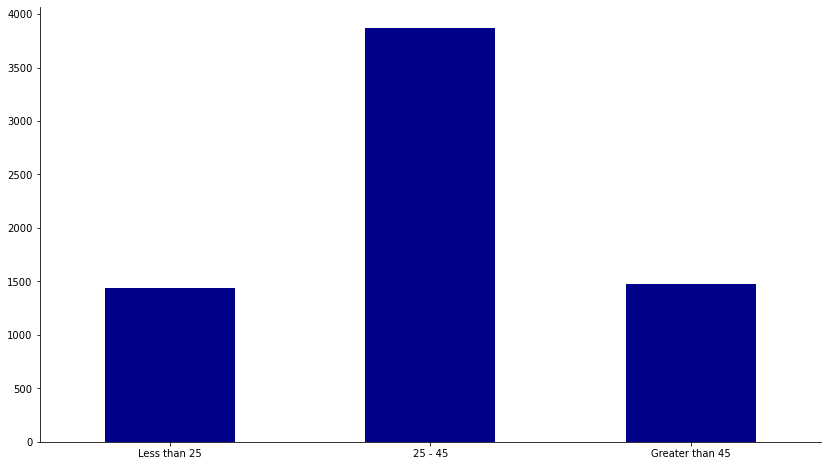

In [5]:
age_cs = ["Less than 25", "25 - 45", "Greater than 45"]
df["age_cat"] = pd.Categorical(df["age_cat"], categories=age_cs, ordered=True)
fig, ax = create_groupcount_barplot(df, "age_cat", (14, 8), color="DarkBlue", rot=0)

(<Figure size 432x576 with 1 Axes>, <AxesSubplot:>)

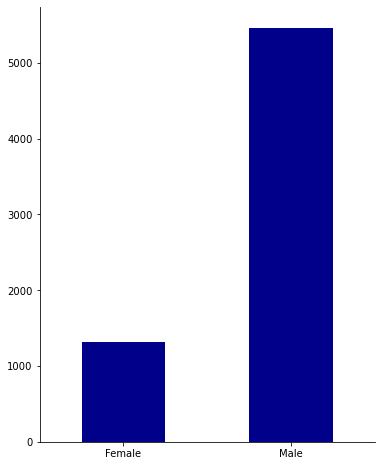

In [6]:
sex_cs = ["Female", "Male"]
df["sex"] = pd.Categorical(df["sex"], categories=sex_cs, ordered=True)
create_groupcount_barplot(df, "sex", (6, 8), color="DarkBlue", rot=0)

(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

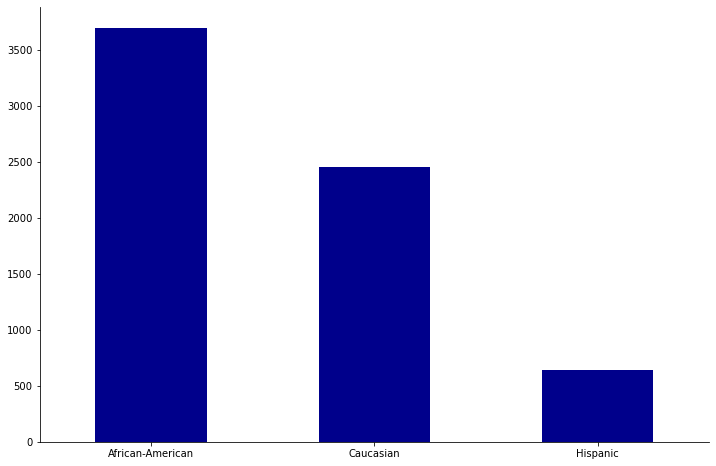

In [7]:
race_cs = ["African-American", "Caucasian", "Hispanic"]
df["race"] = pd.Categorical(df["race"], categories=race_cs, ordered=True)
create_groupcount_barplot(df, "race", (12, 8), color="DarkBlue", rot=0)

* From this, we learn that our population is mostly between 25-45, male, and is mostly African-American or Caucasian.



### Recidivism¶

In [8]:
recid = df.groupby(["age_cat", "sex", "race"])["two_year_recid"].mean().unstack(level="race")
recid

race                    African-American  Caucasian  Hispanic
age_cat         sex                                          
Less than 25    Female          0.449704   0.310345  0.411765
                Male            0.645806   0.541254  0.536364
25 - 45         Female          0.382278   0.423948  0.333333
                Male            0.533074   0.433699  0.375000
Greater than 45 Female          0.227273   0.239766  0.217391
                Male            0.425101   0.289157  0.216667

* In the table, we see that the young have higher recidivism rates than the old, except for among Caucasian females.

* Also, African-American males are at a particularly high risk of recidivism even as they get older.

# Risk Scores

* Each individual in the dataset was assigned a decile_score ranging from 1 to 10.

* This score represents the perceived risk of recidivism with 1 being the lowest risk and 10 being the highest.

(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

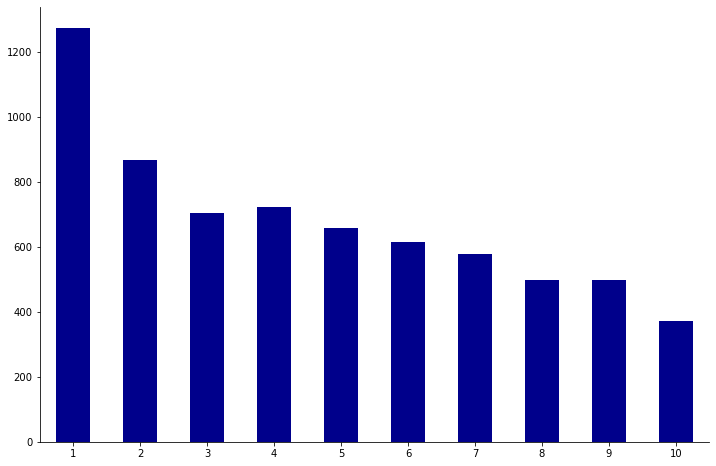

In [9]:
create_groupcount_barplot(df, "decile_score", (12, 8), color="DarkBlue", rot=0)

Text(0.5, 0.98, 'Score Frequency by Race')

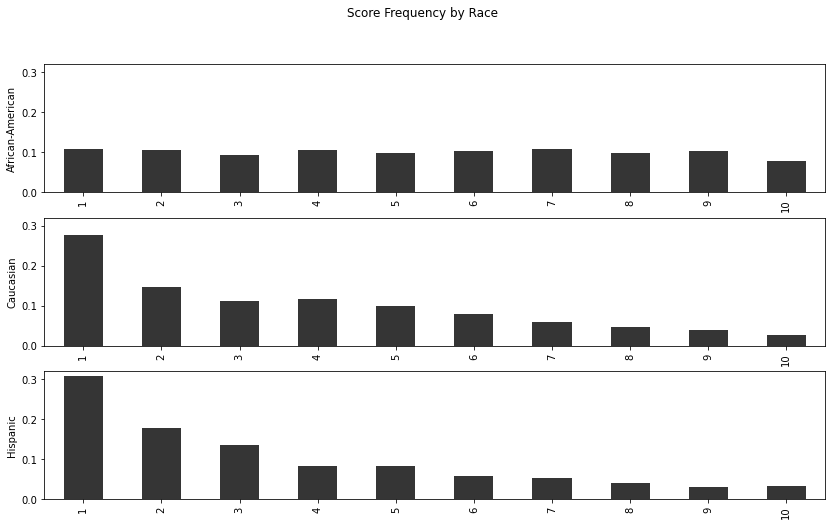

In [10]:
dfgb = df.groupby("race")
race_count = df.groupby("race")["name"].count()

fig, ax = plt.subplots(3, figsize=(14, 8))

for (i, race) in enumerate(["African-American", "Caucasian", "Hispanic"]):
    (
        (dfgb
            .get_group(race)
            .groupby("decile_score")["name"].count() / race_count[race]
        )
        .plot(kind="bar", ax=ax[i], color="#353535")
    )
    ax[i].set_ylabel(race)
    ax[i].set_xlabel("")
    # set equal y limit for visual comparison
    ax[i].set_ylim(0, 0.32)

fig.suptitle("Score Frequency by Race")

* While Caucasians and Hispanics both see the majority of their score distribution on low values, African-Americans are almost equally likely to receive any score.

# Risk Scores and Recidivism

In [11]:
df.groupby("decile_score")["two_year_recid"].mean()

decile_score
1     0.220392
2     0.309112
3     0.375887
4     0.426593
5     0.478723
6     0.564228
7     0.590988
8     0.681363
9     0.698795
10    0.770889
Name: two_year_recid, dtype: float64

In [12]:
df[["decile_score", "two_year_recid"]].corr()

,decile_score,two_year_recid
decile_score,1.000000,0.346797
two_year_recid,0.346797,1.000000


* As the risk score increases, the percentage of people committing a new crime does as well, with a positive correlation (~0.35).

In [13]:
recid_rates = df.pivot_table(index="decile_score", columns="race", values="two_year_recid")

recid_rates

race,African-American,Caucasian,Hispanic
decile_score,,,
1,0.228643,0.208517,0.244898
2,0.302799,0.313019,0.318584
3,0.419075,0.340659,0.313953
4,0.459740,0.396491,0.346154
5,0.482192,0.460581,0.538462
6,0.559896,0.572165,0.567568
7,0.592500,0.615385,0.470588
8,0.682451,0.719298,0.500000
9,0.707895,0.693878,0.550000


# Regression

In [14]:
def prep_data(df, continuous_variables, categories, y_var, test_size=0.15):

    ohe = preprocessing.OneHotEncoder(sparse=False)

    y = df[y_var].values
    X = np.zeros((y.size, 0))

    # Add continuous variables if exist
    if len(continuous_variables) > 0:
        X = np.hstack([X, df[continuous_variables].values])

    if len(categories) > 0:
        X = np.hstack([X, ohe.fit_transform(df[categories])])

    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=test_size, random_state=42
    )

    return X_train, X_test, y_train, y_test

In [16]:
def fit_and_report_maes(mod, X_train, X_test, y_train, y_test, y_transform=None, y_inv_transform=None):
    if y_transform is not None:
        mod.fit(X_train, y_transform(y_train))
    else:
        mod.fit(X_train, y_train)

    yhat_train = mod.predict(X_train)
    yhat_test = mod.predict(X_test)

    if y_transform is not None:
        yhat_train = y_inv_transform(yhat_train)
        yhat_test = y_inv_transform(yhat_test)

    return dict(
        mae_train=metrics.mean_absolute_error(y_train, yhat_train),
        mae_test=metrics.mean_absolute_error(y_test, yhat_test)
    )

In [17]:
X_train, X_test, y_train, y_test = prep_data(
    df, ["priors_count"], [], "decile_score"
)

fit_and_report_maes(linear_model.LinearRegression(), X_train, X_test, y_train, y_test)

{'mae_train': 2.162527833108664, 'mae_test': 2.191754484529134}

* Below, we create a histogram which shows the distribution of these errors. In our case, we take the difference between predicted value and actual value, so a positive value means that we overpredicted the COMPAS score and a negative value means we underpredicted it.

Text(0.5, 1.0, 'Test Data')

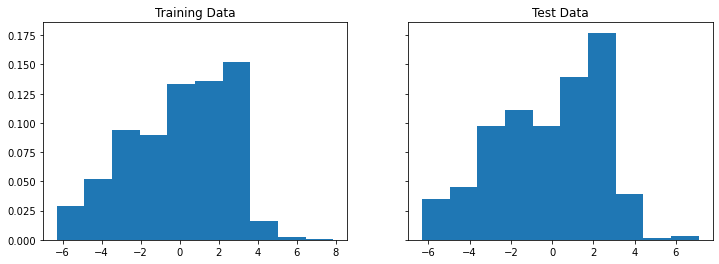

In [19]:
lr_model = linear_model.LinearRegression()
lr_model.fit(X_train, y_train)

yhat_train = lr_model.predict(X_train)
yhat_test = lr_model.predict(X_test)

fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey="all")

ax[0].hist(yhat_train - y_train, density=True)
ax[0].set_title("Training Data")
ax[1].hist(yhat_test - y_test, density=True)
ax[1].set_title("Test Data")

Text(0.5, 1.0, 'Test Data')

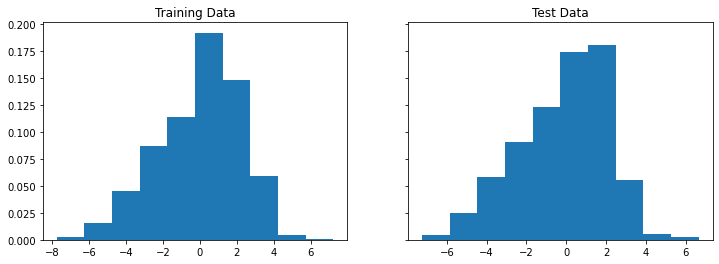

In [20]:
X_train, X_test, y_train, y_test = prep_data(
    df, ["priors_count"], ["age_cat", "race", "sex"], "decile_score"
)

lr_model = linear_model.LinearRegression()
lr_model.fit(X_train, y_train)

yhat_train = lr_model.predict(X_train)
yhat_test = lr_model.predict(X_test)

fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey="all")

ax[0].hist(yhat_train - y_train, density=True)
ax[0].set_title("Training Data")
ax[1].hist(yhat_test - y_test, density=True)
ax[1].set_title("Test Data")

In [21]:
names = [
    "priors_count", "Less than 25", "25-45", "Greater than 45", "African-American",
    "Caucasian", "Hispanic", "Female", "Male"
]
for (_name, _coef) in zip(names, lr_model.coef_):
    print(_name, ": ", _coef)

priors_count :  0.27999230496845817
Less than 25 :  -0.10262755807946529
25-45 :  -1.7189018948181354
Greater than 45 :  1.8215294528975994
African-American :  0.6102522379830795
Caucasian :  -0.1015693968944254
Hispanic :  -0.5086828410886546
Female :  0.042935824274662034
Male :  -0.042935824274662034


# Conditional Probabilities

In [22]:
from patsy import dmatrices
groups = [
    "overall", "African-American", "Caucasian", "Hispanic", "Female", "Male"
]

ind = [
    "Portion_of_NoRecid_and_LowRisk", "Portion_of_Recid_and_LowRisk",
    "Portion_of_NoRecid_and_HighRisk", "Portion_of_Recid_and_HighRisk"
]

fmla = "two_year_recid ~ C(decile_score)"
y,X = dmatrices(fmla, df)
X_train, X_test, y_train, y_test, df_train, df_test = model_selection.train_test_split(
    X,y.reshape(-1),df, test_size=0.25, random_state=42
)


decile_mod = linear_model.LogisticRegression(solver="lbfgs").fit(X_train,y_train)

def cm_tables(pred, y, df):
    output = pd.DataFrame(index=ind, columns=groups)
    for group in groups:
        if group in ["African-American", "Caucasian", "Hispanic"]:
            subset=(df.race==group)
        elif group in ["Female", "Male"]:
            subset=(df.sex==group)
        else:
            subset=np.full(y.shape, True)

        y_sub = y[subset]
        pred_sub = pred[subset]

        cm = metrics.confusion_matrix(y_sub, pred_sub)

        # Compute fraction for which the guess is correct
        total = cm.sum()
        vals = np.array(cm/total)
        output.loc[:, group] = vals.reshape(-1)


    def cond_probs(col, axis):
        d=int(np.sqrt(len(col)))
        pcm = np.array(col).reshape(d,d)
        pcm = pcm/pcm.sum(axis=axis, keepdims=True)
        return(pcm.reshape(-1))

    given_outcome = output.copy()
    given_outcome.index = ["P(LowRisk|NoRecid)","P(HighRisk|NoRecid)","P(LowRisk|Recid)","P(HighRisk|Recid)"]
    given_outcome=given_outcome.apply(lambda c: cond_probs(c,1))

    given_pred = output.copy()
    given_pred.index = ["P(NoRecid|LowRisk)","P(NoRecid|HighRisk)","P(Recid|LowRisk)","P(Recid|HighRisk)"]
    given_pred=given_pred.apply(lambda c: cond_probs(c,0))
    return(output,given_outcome, given_pred)

output, given_outcome, given_pred =cm_tables(decile_mod.predict(X_test),
                                             y_test, df_test)
output


,overall,African-American,Caucasian,Hispanic,Female,Male
Portion_of_NoRecid_and_LowRisk,0.361815,0.263270,0.475000,0.522581,0.438040,0.342222
Portion_of_Recid_and_LowRisk,0.191514,0.230361,0.136667,0.167742,0.207493,0.187407
Portion_of_NoRecid_and_HighRisk,0.152033,0.140127,0.168333,0.161290,0.141210,0.154815
Portion_of_Recid_and_HighRisk,0.294638,0.366242,0.220000,0.148387,0.213256,0.315556


In [23]:
given_pred

,overall,African-American,Caucasian,Hispanic,Female,Male
P(NoRecid|LowRisk),0.704128,0.652632,0.738342,0.764151,0.756219,0.688525
P(NoRecid|HighRisk),0.393939,0.386121,0.383178,0.530612,0.493151,0.372607
P(Recid|LowRisk),0.295872,0.347368,0.261658,0.235849,0.243781,0.311475
P(Recid|HighRisk),0.606061,0.613879,0.616822,0.469388,0.506849,0.627393


In [24]:
given_outcome

,overall,African-American,Caucasian,Hispanic,Female,Male
P(LowRisk|NoRecid),0.653887,0.533333,0.776567,0.757009,0.678571,0.646154
P(HighRisk|NoRecid),0.346113,0.466667,0.223433,0.242991,0.321429,0.353846
P(LowRisk|Recid),0.340369,0.276730,0.433476,0.520833,0.398374,0.329134
P(HighRisk|Recid),0.659631,0.723270,0.566524,0.479167,0.601626,0.670866


* Now we see some large disparities by race in the false positive rate (and false negative rate). 